<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
##<u>Michigan Crop Yield vs. Weather Analysis</u>
The US government makes lots of data freely available, including historical weather and crop yield measurements.  Let's have a look to see whether any simple annual weather metrics correlate with yields for Michigan's major crops:  beans, corn, hay, soybeans, sugarbeets, and wheat.  (I'd like to look at fruit crops like apples and cherries, too, but historical data for those crops goes back only about 10 years)

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Package imports
- Third party tools for loading/processing/plotting the data

In [1]:
%matplotlib inline
import pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
from IPython.html import widgets
from collections import defaultdict

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Load historical yield data 
- obtained from USDA National Agricultural Statistics Service: http://quickstats.nass.usda.gov/

In [2]:
# load the CSV file using pandas
df_yield = pd.read_csv('ED1636E9-9799-38A8-B143-2380DAE09720.csv', usecols=['Year', 'State', 'Commodity', 'Data Item', 'Value'])

# 'Value' is the yield column, and it uses a thousands separator which prevents pandas from casting it to float.  Let's fix that.
df_yield['Value'] = df_yield['Value'].map(lambda x: float(x.replace(',', '')))

# sort by year/commodity/state
df_yield.sort(['Year', 'Commodity', 'State'], inplace=True)

# yield units are different for different commodities - let's capture this in a dictionary for convenience later
commodity_to_yield_units = pd.pivot_table(df_yield, index='Commodity', values='Data Item', 
               aggfunc=lambda x: set(x).pop().split('MEASURED IN ')[-1].lower().capitalize().replace(' ', '')).to_dict()

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
### Group the yield data by commodity, then pivot the results into a more convenient format
- Each commodity's data frame has columns for year, Michigan yield, US total yield, and normalized yield (Michigan / US)


In [3]:
commodity_to_df = dict()
for commodity, df_c in df_yield.groupby('Commodity'):
    df_pivot = df_c.pivot(index='Year', columns='State', values='Value')
    df_pivot.dropna(inplace=True)
    df_pivot['Normalized Yield'] = df_pivot['MICHIGAN'] / df_pivot['US TOTAL']
    df_pivot.rename(columns={'MICHIGAN': 'Michigan Yield', 'US TOTAL': 'US Total'}, inplace=True)
    commodity_to_df[commodity] = df_pivot

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Let's have a quick peek: plot historical yield data for Michigan and US total

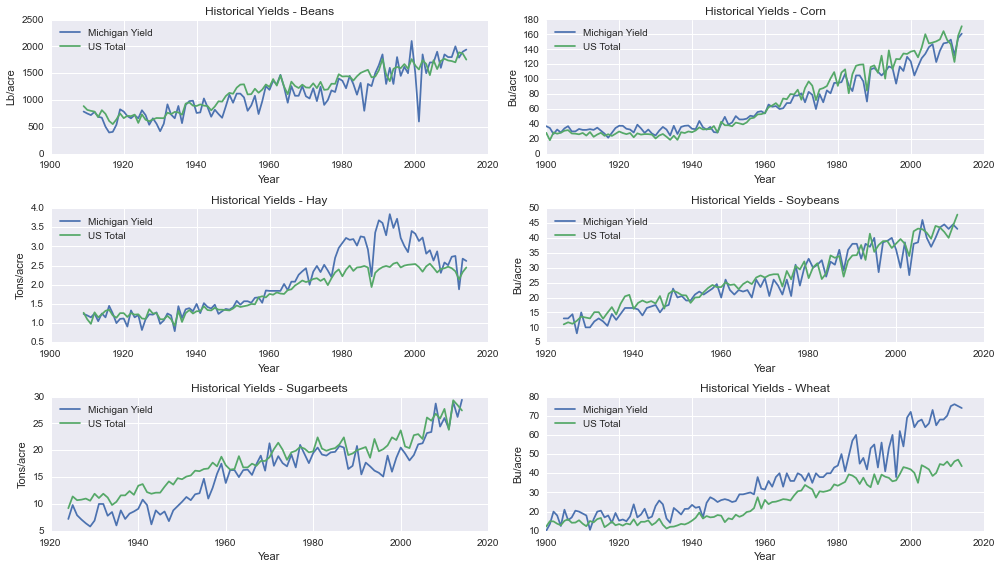

In [4]:
plt.figure(figsize=(14,8))
for i, commodity in enumerate(sorted(commodity_to_df.keys())):
    df_c = commodity_to_df[commodity]
    plt.subplot(3,2,i+1)
    plt.hold(True)
    for column in ('Michigan Yield', 'US Total'):
        plt.plot(df_c.index, df_c[column], label=column)

    plt.legend(loc=0)
    plt.title('Historical Yields - %s' % commodity.lower().capitalize())
    plt.xlabel('Year')
    plt.ylabel(commodity_to_yield_units[commodity])
    
plt.tight_layout();

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Can't stop the (farm) science
Yields have grown steadily over the past century for all of Michigan's major crops.  Michigan's yields closely track the national average, with a few exceptions:
- Hay yields were substantially higher than the national average from approximately 1975 to 2005
- Sugarbeet yields are somewhat lower than the national average, with two protracted dips in relative production (1920-1960, 1990-2000) 
- Wheat yields are consistently higher than the national average

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Let's see how weather factors in
- Load and prepare weather data downloaded from NOAA:  http://www.ncdc.noaa.gov/cdo-web


In [5]:
df_weather = pd.read_csv('449958.csv', usecols=['STATION_NAME', 'DATE', 'TMIN', 'TMAX', 'PRCP'])

# limit to UofM weather station, as it has the most complete history
df_weather = df_weather[df_weather['STATION_NAME'] == 'ANN ARBOR UNIVERSITY OF MI MI US']
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], format='%Y%m%d')
df_weather.sort('DATE', inplace=True)

# decompose date into year/month/day of year columns
df_weather['Year'] = df_weather['DATE'].map(lambda x: x.year)
df_weather['Month'] = df_weather['DATE'].map(lambda x: x.month)
df_weather['Day of year'] = df_weather['DATE'].map(lambda x: x.dayofyear)
df_weather.set_index('DATE')

# replace the -9999 values with nans to be more explicit
df_weather = df_weather.applymap(lambda x: np.nan if x == -9999 else x)

# create columns for max/min temp in deg. F (provided in 1/10th deg C)
df_weather['Max Temp Fahrenheit'] = \
    df_weather['TMAX'].map(lambda x: (x / 10.0) * 9.0/5 + 32)

df_weather['Min Temp Fahrenheit'] = \
    df_weather['TMIN'].map(lambda x: (x / 10.0) * 9.0/5 + 32)
    
# create 'crop year' column for use in aligning precipitation metrics to the crop cycle, rather than Julian calendar
df_weather['Crop Year'] = df_weather['DATE'].map(lambda x: x.year if x.month < 10 else x.year + 1)

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Calculate some weather point metrics that might be correlated with annual yields:
- Date of last freeze (days since 1/1)
- Average max daily summer temp
- Annual precipitation total
- Monthly preciptation totals

In [6]:
def merge_factor_with_commodity_histories(df_factor):
    for commodity, df_c in commodity_to_df.items():
        commodity_to_df[commodity] = pd.merge(df_c, df_factor, left_index=True, right_index=True)
        commodity_to_df[commodity].dropna(inplace=True)

factor_names = []
# Date of last freeze
last_freeze = pd.pivot_table(
                    df_weather[~np.isnan(df_weather['Min Temp Fahrenheit']) &
                               (df_weather['Month'] < 6) & 
                               (df_weather['Min Temp Fahrenheit'] < 30)],
                    index=['Year'], values=['Day of year'], aggfunc=max)

# Relable the 'Day of year' column to be more descriptive
label = 'Date of Last Freeze'
factor_names.append(label)
last_freeze.rename(columns={'Day of year': label}, inplace=True)
merge_factor_with_commodity_histories(last_freeze)


# Max summer temp
avg_max_summer_temp = pd.pivot_table(
                        df_weather[(df_weather['Month'] > 4) & (df_weather['Month'] < 10)],
                        index=['Year'], values=['Max Temp Fahrenheit'], aggfunc=np.mean)
label = 'Avg. Max Summer Temp (F)'
factor_names.append(label)
avg_max_summer_temp.rename(columns={'Max Temp Fahrenheit': label}, inplace=True)
merge_factor_with_commodity_histories(avg_max_summer_temp)

# Annual precipitation (by crop year)
total_precip = pd.pivot_table(df_weather, index=['Crop Year'], values=['PRCP'], 
                              aggfunc=lambda x: sum(x)/254.)  # convert 10ths of mm to inches
label = 'Total Annual Precip.'
factor_names.append(label)
total_precip.rename(columns={'PRCP': label}, inplace=True)
merge_factor_with_commodity_histories(total_precip)

# Monthly precipitation (by crop year)
for month, df_month in df_weather.groupby('Month'):
    month_precip = pd.pivot_table(df_month, index=['Crop Year'], values=['PRCP'], 
                              aggfunc=lambda x: sum(x)/254.)
    months = ['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
    label = '%s Total Precip.' % months[month-1]
    factor_names.append(label)
    month_precip.rename(columns={'PRCP': label}, inplace=True)
    merge_factor_with_commodity_histories(month_precip)

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Look at correlations between weather factors and commodity yields

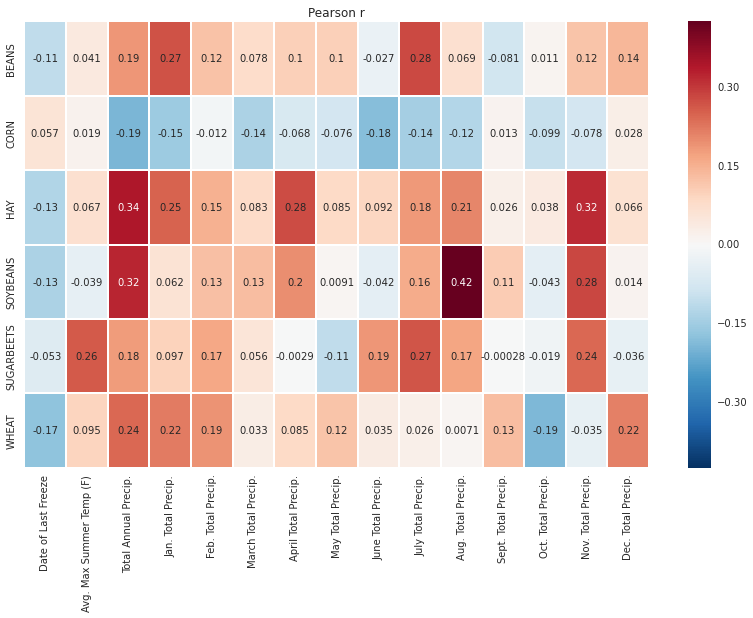

In [78]:
def draw_heatmap(metric, normalize_yield_by_US_total):
    heatmap = np.zeros((len(commodity_to_df.keys()), len(factor_names)))
    if normalize_yield_by_US_total:
        michigan_or_normalized = 'Normalized'
    else:
        michigan_or_normalized = 'Michigan'

    for i, commodity in enumerate(sorted(commodity_to_df)):
        df_c = commodity_to_df[commodity]
        for j, factor in enumerate(factor_names):
            r, p_norm = scipy.stats.pearsonr(df_c[factor], df_c['%s Yield' % michigan_or_normalized])
            if metric == 'r^2':
                heatmap[i, j] = r*r
            elif metric == 'Pearson r':
                heatmap[i, j] = r
            else:
                heatmap[i, j] = p_norm

    plt.figure(figsize=(14,8))
    sns.heatmap(heatmap, annot=True, xticklabels=factor_names, yticklabels=sorted(commodity_to_df.keys()))
    plt.title(metric)

widgets.interact(draw_heatmap, 
                 metric=['Pearson r', 'r^2', 'p-value'],
                 normalize_yield_by_US_total=False);

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
### Clearly, precipitation has something to do yield.
Also, date of last freeze has negative correlations with yield.  This makes sense!

... wait, shouldn't we be looking at the relative yields?  We know the primary factor affecting yields has been time, and the technologicial advances that have come with it (mechanical equipment, nitrogen fertilizers and other petroleum-based inputs, GMOs, etc.).  Maybe we've just been getting wetter and warmer over the years, too.

Better tick that "normalize_by_us_total" box to see if relative yields have these same sensible associations.  I'll wait here.

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Okay, normalized yield data doesn't look quite so clear.
- The general trend of negative correlation with date of last freeze and positive correlations with precipitation and temperature hold
    - Except for corn.  Maybe corn really doesn't like so much water?
- On the other hand, maybe we just exposed more sensitive relationships 
    - is the strong correlation between August precipitation and soybean yields real?
    - how about the negative correlation between June precipitation and corn yields?

###Let's take a more detailed look at individual commodity/factor pairs

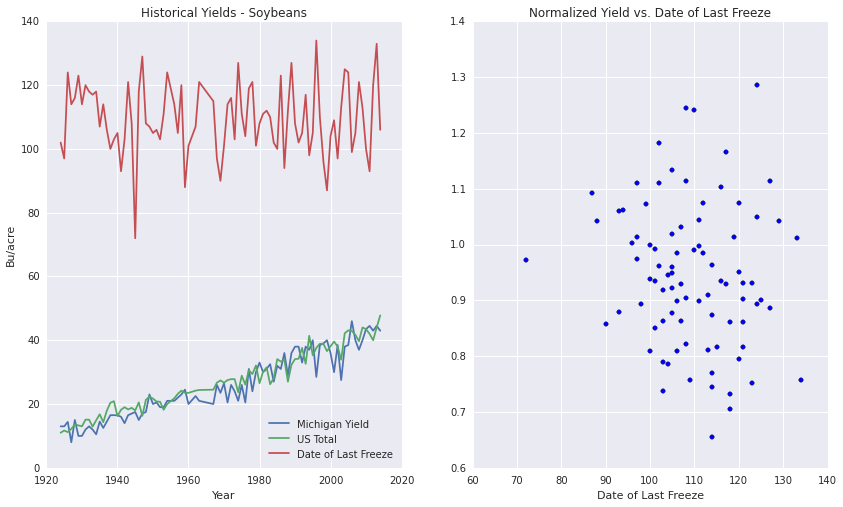

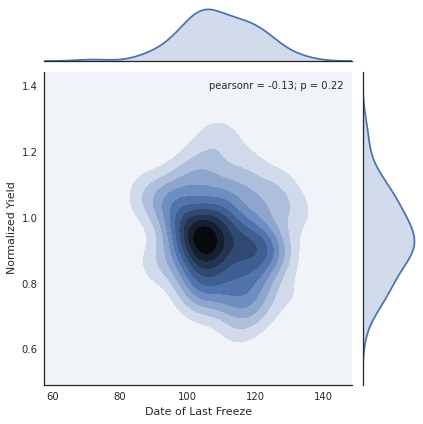

In [79]:
def interact(commodity, factor, normalize_yield_by_US_total, estimate_kernel_density):
    unit = commodity_to_yield_units[commodity]
    df = commodity_to_df[commodity]
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    plt.plot(df.index, df['Michigan Yield'], label='Michigan Yield')
    plt.plot(df.index, df['US Total'], label='US Total')
    plt.plot(df.index, df[factor], label=factor)
    plt.legend(loc=0)
    plt.title('Historical Yields - %s' % commodity.lower().capitalize())
    plt.xlabel('Year')
    plt.ylabel(unit)

    if normalize_yield_by_US_total:
        michigan_or_normalized = 'Normalized'
    else:
        michigan_or_normalized = 'Michigan'

    plt.subplot(122)
    plt.scatter(df[factor], df['%s Yield' % michigan_or_normalized])
    plt.xlabel(factor)
    plt.title('%s Yield vs. %s' % (michigan_or_normalized, factor))


    with sns.axes_style("white"):
        sns.jointplot(df[factor], df['%s Yield' % michigan_or_normalized], kind='kde' if estimate_kernel_density else 'hex')
        
widgets.interact(interact, commodity=sorted(commodity_to_yield_units.keys()), factor=factor_names, 
                 estimate_kernel_density=False, normalize_yield_by_US_total=False);    

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###That didn't help much.
A couple of ideas that might clarify matters:
- Normalize weather factors by regional/national trends.  As it stands, if the US had an unusually wet year overall, the (ostensibly positive) affect on crop yields will be wiped out when looking at normalized yields
    - That's a TODO.  Estimating regional weather trends is a hairier beast, and to do it right, we'd want to focus on regions that produce the same crops
- Look at how these individual factors act in tandem - multivariate analysis

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Multi-variate analysis
Do stepwise regression on each commodity's yield to the various weather factors.  See which factors are most heavily weighted, and how well a linear model composed of these factors can predict actual yield.

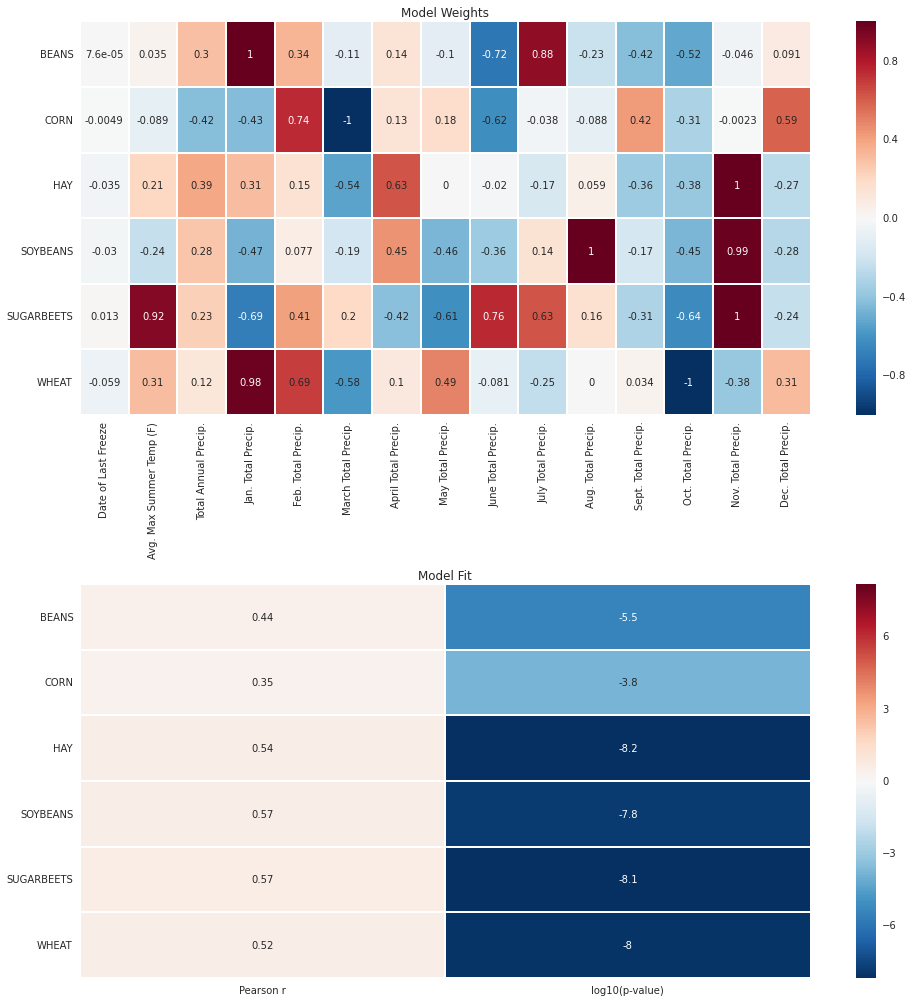

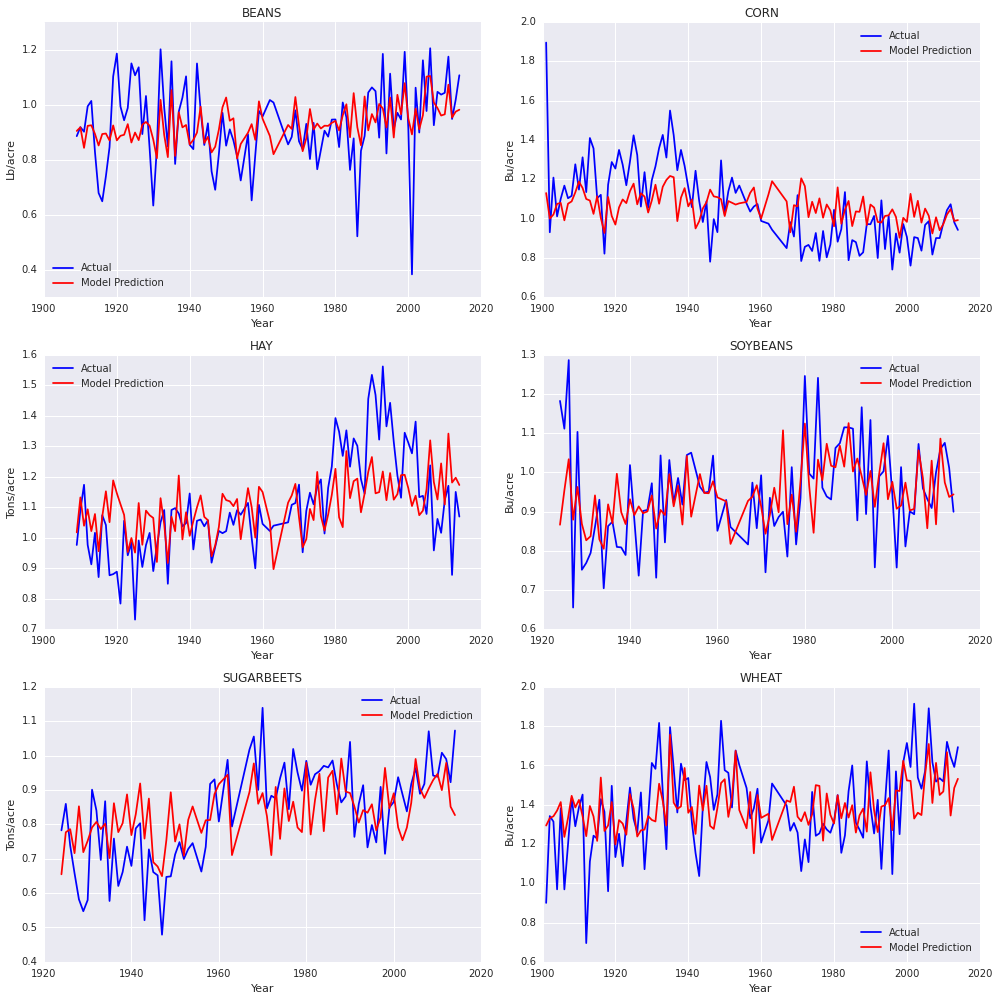

In [80]:
def stepwise_regression(A, y):
    p = 1
    rho = 0
    cols = []
    weights = []
    yhat = []
    while True:
        p_best_col = best_col = None
        for col in xrange(A.shape[1] - 1):
            if col in cols:
                continue
            test_cols = cols[:]
            test_cols.append(col)
            test_cols.append(A.shape[1]-1)  # bias
            A_test = A[:, test_cols]
            try:
                weights = np.matrix(np.linalg.lstsq(A_test, y)[0])
            except:
                continue
                
            yhat_col = A_test * weights
            r, p_col = scipy.stats.pearsonr(np.asarray(y.T)[0], np.asarray(yhat_col.T)[0])
            if p_best_col is None or p_col < p_best_col:
                p_best_col = p_col
                best_col = col
        
        if p_best_col is not None and p_best_col < p:
            p = p_best_col
            rho = r
            yhat = yhat_col
            weights = weights
            cols.append(best_col)
        else:
            break
    
    cols.append(A.shape[1]-1)
    return max(1e-50, p), rho, cols, weights, yhat

def draw_model_and_predictions(measure, normalize_model_weights):
    col_names = factor_names[:]
    heatmap_weights = np.zeros((len(commodity_to_df.keys()), len(col_names)))
    heatmap_model = np.zeros((len(commodity_to_df.keys()), 2))
    ys = []
    yhats = []
    for row, commodity in enumerate(sorted(commodity_to_df)):
        df = commodity_to_df[commodity]
        x = df.as_matrix(columns=factor_names)
        y = df.as_matrix(columns=[measure])
        A = np.hstack((x, np.ones((x.shape[0], 1))))
        p, rho, cols, weights, yhat = stepwise_regression(A, y)
        ys.append(y)
        yhats.append(yhat)
        absmax = max(np.abs(weights[:-1]))
        for (col, weight) in zip(cols, weights):
            if col == len(factor_names):  # bias weight
                continue
                
            heatmap_weights[row, col] = weight
            if normalize_model_weights:
                heatmap_weights[row, col] /= absmax

        heatmap_model[row, 0] = rho
        heatmap_model[row, 1] = np.log10(p)
        
    plt.figure(figsize=(14, 14))
    plt.subplot(211)
    sns.heatmap(heatmap_weights, annot=True, xticklabels=col_names, yticklabels=sorted(commodity_to_df.keys()))
    plt.title('Model Weights')
    plt.subplot(212)
    sns.heatmap(heatmap_model, annot=True, xticklabels=['Pearson r', 'log10(p-value)'], yticklabels=sorted(commodity_to_df.keys()))
    plt.title('Model Fit')
    plt.tight_layout()

    plt.figure(figsize=(14, 14))
    for i, (y, yhat, commodity) in enumerate(zip(ys, yhats, sorted(commodity_to_df.keys()))):
        plt.subplot(3, 2, i+1)
        plt.plot(commodity_to_df[commodity].index, y, 'b', label='Actual')
        plt.hold(True)
        plt.plot(commodity_to_df[commodity].index, yhat, 'r', label='Model Prediction')
        plt.title(commodity)
        plt.xlabel('Year')
        plt.ylabel(commodity_to_yield_units[commodity])
        plt.legend(loc=0)
    plt.tight_layout()

    
widgets.interact(draw_model_and_predictions, measure=['Normalized Yield', 'Michigan Yield', 'US Total'], normalize_model_weights=True);

<div style="background-color:rgba(80, 30, 10, 0.1); padding:10px; padding-bottom:20px">
###Very interesting that each crop has a couple of key months where precipitation plays a major role in the model output
- Different months for each crop
    
###But I'm out of time
What I'd do next:
- Do a proper analysis with separate train and test sets
- Include previous year's yield as model input
- Try non-linear models
- Normalize weather to region
- See if precipitation's influence changes over time
    - to account for adoption of irrigation 
- ANOVA on crop-specific factors
    - early vs. late germination/harvest
    - above vs. under ground
    - etc.